# QSIRecon parcellation demo

Load a QSIRecon derivative, plan atlas/scalar jobs, and run parcellation using `qsiparc`.
This example uses a tiny synthetic dataset if `DATA_ROOT` is missing; point it to your real derivative to run on actual outputs.


In [1]:
from pathlib import Path

import nibabel as nib
import numpy as np

from qsiparc.parcellation.settings import load_settings
from qsiparc.io.loaders import load_recon_inputs
from qsiparc.workflows.planner import plan_parcellations
from qsiparc.parcellation.runner import run_parcellation

DATA_ROOT = Path("/media/storage/yalab-dev/qsiprep_test/derivatives/qsirecon")
CONFIG_PATH = Path("/home/galkepler/Projects/qsiparc/parcellation.example.toml")


## Create a minimal synthetic derivative (only if needed)
This fabricates a single subject with one scalar map (`dwimap`) and a matching atlas in MNI space.
Skip or delete if you're pointing at a real dataset.


In [2]:
def ensure_demo_dataset(root: Path) -> None:
    root.mkdir(parents=True, exist_ok=True)
    (root / "dataset_description.json").write_text("{\"Name\": \"qsirecon-demo\", \"BIDSVersion\": \"1.8.0\", \"DatasetType\": \"derivative\"}")
    # scalar map
    dwi_dir = root / "sub-01" / "dwi"
    dwi_dir.mkdir(parents=True, exist_ok=True)
    scalar = np.array([[[0.0, 1.0], [3.0, 5.0]]], dtype=np.float32)
    nib.Nifti1Image(scalar, affine=np.eye(4)).to_filename(dwi_dir / "sub-01_desc-fa_dwimap.nii.gz")
    # atlas in same space
    anat_dir = root / "sub-01" / "anat"
    anat_dir.mkdir(parents=True, exist_ok=True)
    atlas = np.array([[[0, 1], [1, 2]]], dtype=np.int16)
    nib.Nifti1Image(atlas, affine=np.eye(4)).to_filename(
        anat_dir / "sub-01_space-MNI152NLin2009cAsym_atlas-demo_dseg.nii.gz"
    )

if not DATA_ROOT.exists():
    ensure_demo_dataset(DATA_ROOT)


## Load settings and data
Settings come from `parcellation.example.toml`. Adjust metrics/resampling there; masks support path or `gm`/`wm`/`csf`.


In [3]:
settings = load_settings(CONFIG_PATH)
recon_inputs = load_recon_inputs(root=DATA_ROOT, subjects=["CLMC10"])
recon_inputs


[ReconInput(context=SubjectContext(subject_id='CLMC10', session_id='202407110849'), atlases=[AtlasDefinition(name='4S156Parcels', nifti_path=PosixPath('/media/storage/yalab-dev/qsiprep_test/derivatives/qsirecon/atlases/atlas-4S156Parcels/atlas-4S156Parcels_space-MNI152NLin2009cAsym_res-01_dseg.nii.gz'), lut=PosixPath('/media/storage/yalab-dev/qsiprep_test/derivatives/qsirecon/atlases/atlas-4S156Parcels/atlas-4S156Parcels_dseg.tsv'), resolution='01', space='MNI152NLin2009cAsym'), AtlasDefinition(name='4S256Parcels', nifti_path=PosixPath('/media/storage/yalab-dev/qsiprep_test/derivatives/qsirecon/atlases/atlas-4S256Parcels/atlas-4S256Parcels_space-MNI152NLin2009cAsym_res-01_dseg.nii.gz'), lut=PosixPath('/media/storage/yalab-dev/qsiprep_test/derivatives/qsirecon/atlases/atlas-4S256Parcels/atlas-4S256Parcels_dseg.tsv'), resolution='01', space='MNI152NLin2009cAsym'), AtlasDefinition(name='4S456Parcels', nifti_path=PosixPath('/media/storage/yalab-dev/qsiprep_test/derivatives/qsirecon/atlases

## Plan atlas/scalar jobs and run parcellation
Planner returns atlas-keyed job lists; runner executes and yields DataFrame-backed results.


In [4]:
plan = plan_parcellations(recon_inputs, settings=settings)


In [5]:
k = 0
key = list(plan.keys())[k]
plan = {key: [p for p in plan[key] if "dki-md" in p.scalar.name.lower()]}

In [7]:
results = run_parcellation(plan)
results


Atlas shape (193, 229, 193) does not match scalar shape (101, 123, 107). Resampling scalar map to atlas/labels grid.


[ParcellationResult(job=ParcellationJob(atlas=AtlasDefinition(name='4S156Parcels', nifti_path=PosixPath('/media/storage/yalab-dev/qsiprep_test/derivatives/qsirecon/atlases/atlas-4S156Parcels/atlas-4S156Parcels_space-MNI152NLin2009cAsym_res-01_dseg.nii.gz'), lut=PosixPath('/media/storage/yalab-dev/qsiprep_test/derivatives/qsirecon/atlases/atlas-4S156Parcels/atlas-4S156Parcels_dseg.tsv'), resolution='01', space='MNI152NLin2009cAsym'), scalar=ScalarMapDefinition(name='dki-md', nifti_path=PosixPath('/media/storage/yalab-dev/qsiprep_test/derivatives/qsirecon/derivatives/qsirecon-DIPYDKI/sub-CLMC10/ses-202407110849/dwi/sub-CLMC10_ses-202407110849_dir-AP_space-MNI152NLin2009cAsym_model-dki_param-md_dwimap.nii.gz'), model='dki', origin='DKI axial diffusivity', space='MNI152NLin2009cAsym'), context=SubjectContext(subject_id='CLMC10', session_id='202407110849'), metrics=('nanmean', 'nanmedian', 'nanstd', 'nanmin', 'nanmax', 'count', 'zfmean', 'iqrmean', 'mad_median'), resample_target='labels', m

## Inspect a result
Each result has `stats` (dict) and `table` (DataFrame with `index`/`label`/metric columns).


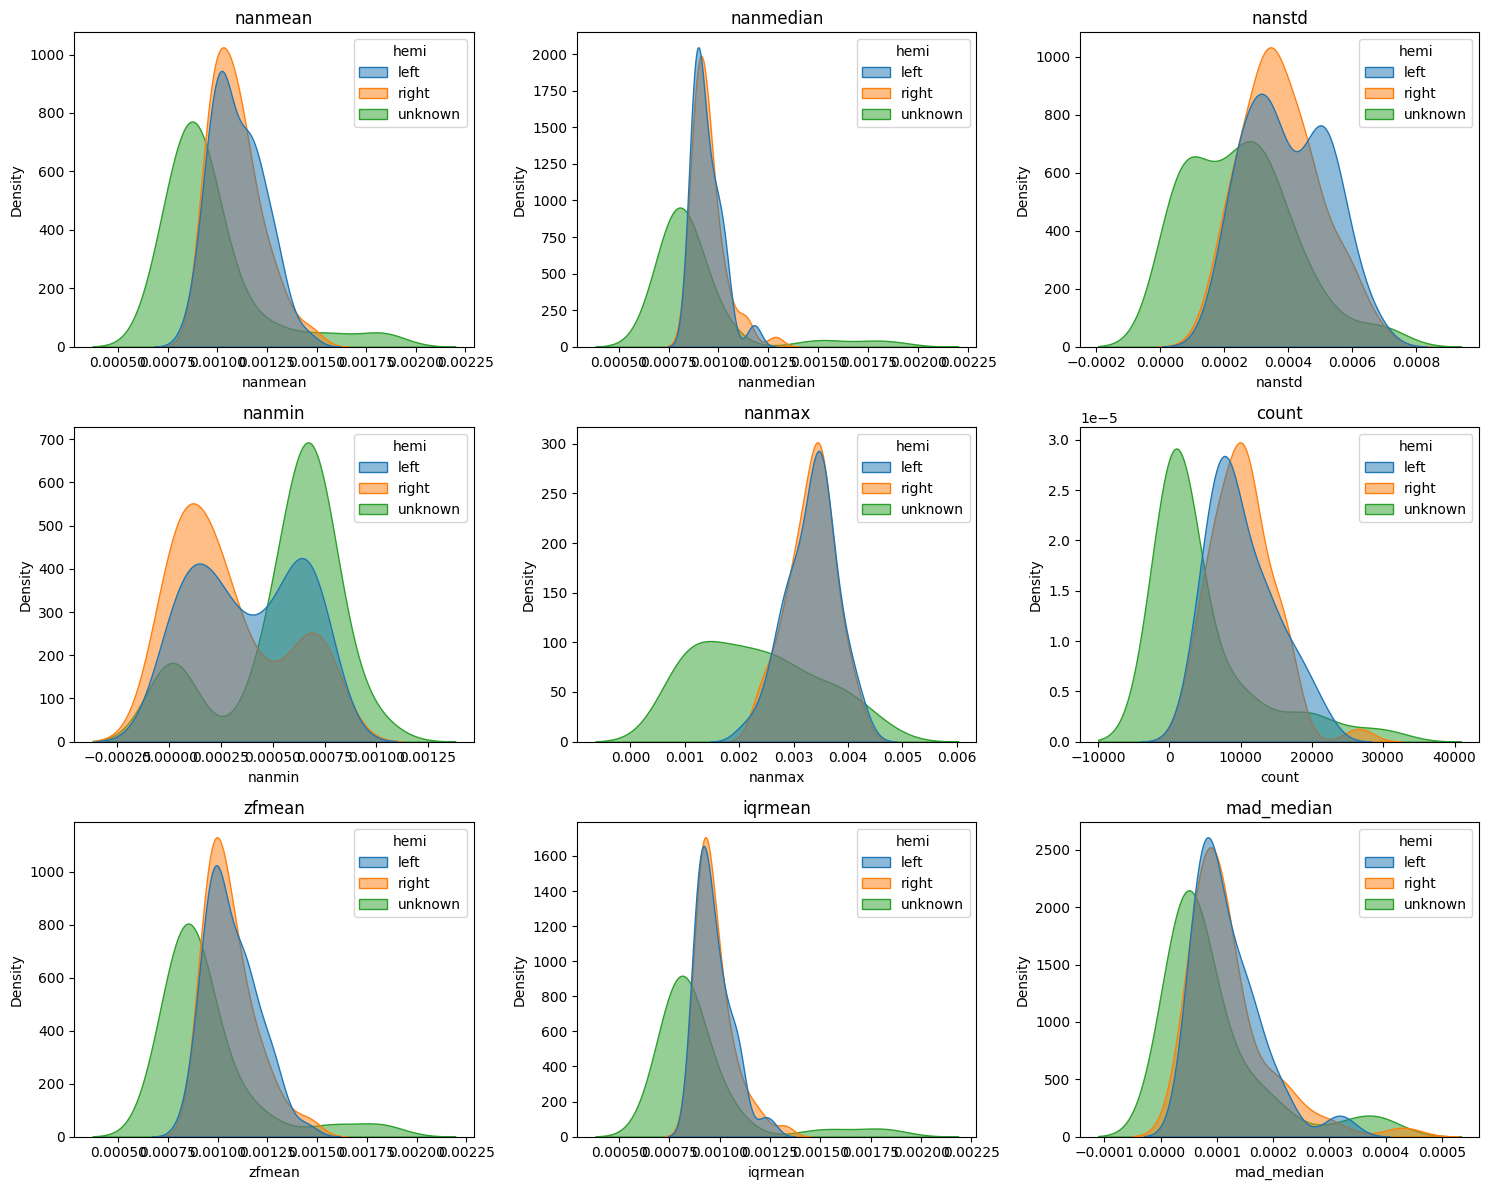

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from qsiparc.parcellation.volume import DEFAULT_ROI_METRIC_NAMES
s = results[0].table
s["hemi"] = s["name"].apply(lambda x: "left" if x.startswith("LH_") else ("right" if x.startswith("RH_") else "unknown"))
cols = list(DEFAULT_ROI_METRIC_NAMES)
n_cols = 3
n_rows = int(np.ceil(len(cols) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
for i, col in enumerate(cols):
    r = i // n_cols
    c = i % n_cols
    ax = axes[r, c] if n_rows > 1 else axes[c]
    sns.kdeplot(data=s, x=col, hue="hemi", fill=True, common_norm=True, alpha=0.5, ax=ax)
    ax.set_title(col)
plt.tight_layout()
plt.show()



In [14]:
# s.sort_values("count")
key

'4S156Parcels:sub-CLMC10_ses-202407110849'